Please run this notebook on Databricks from the given link in the project submission

In [ ]:
pip install torch

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 877.5 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.2 MB/s eta 0:00:00
     ━━

In [ ]:
pip install unidecode

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 5.5 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
import glob
import unidecode
import unicodedata
import string
import torch
import torch.nn as nn
import random
import os
import pickle

In [ ]:
# import argparse
#
# parser=argparse.ArgumentParser()
#
# parser.add_argument("--train", action="store_true", help=".")
#
# args=parser.parse_args()


In [ ]:
train_model = True

In [ ]:
def findFiles(path): return glob.glob(path)

proj_dir = os.path.dirname(os.path.dirname(os.getcwd()))

all_letters = string.ascii_letters + " .,;'"

n_letters = len(all_letters)


# Build the category_lines dictionary, a list of names per language
category_lines_train = {}
category_lines_test = {}
all_categories = []

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

country_path = proj_dir + "/data/countryNames"
for filename in os.listdir(country_path):
    category = filename.split('.')[0]
    all_categories.append(category)
    file_path = os.path.join(country_path, filename)
    lines = readLines(file_path)
    lines_distinct = []
    for line in lines:
        if line not in lines_distinct:
            lines_distinct.append(line)
    random.shuffle(lines_distinct)

    if category == "English" or category == "Russian":
        lines_distinct = lines_distinct[:1000]
    lines_num = len(lines_distinct)

    category_lines_train[category] = lines_distinct[:int((lines_num / 10) * 7)]
    category_lines_test[category] = lines_distinct[int((lines_num / 10) * 7):]


n_categories = len(all_categories)
print(category_lines_train['English'][:5])

train_len = sum([len(category_lines_train[x]) for x in all_categories])
print(len(category_lines_train["English"]))

['Farnworth', 'Forman', 'Gough', 'Hassan', 'Cooke']
700


In [ ]:

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return torch.tensor(all_letters.find(letter), dtype=torch.long).unsqueeze(0)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    return torch.nn.functional.one_hot(letterToIndex(letter) ,num_classes=n_letters)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    return torch.nn.functional.one_hot(
        torch.stack([letterToIndex(letter) for letter in line]),
        num_classes=n_letters
    )

In [ ]:

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h1 = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o1 = nn.Linear(input_size + hidden_size, input_size)
        self.i2h2 = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o2 = nn.Linear(input_size + hidden_size, input_size)
        self.i2h3 = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o3 = nn.Linear(input_size + hidden_size, output_size)

        self.logsoftmax = nn.LogSoftmax(dim=-1)

        self.tanh1 = nn.Tanh()
        self.tanh2 = nn.Tanh()
        self.tanh3 = nn.Tanh()


    def forward(self, input, hidden1, hidden2, hidden3):

        combined1 = torch.cat((input, hidden1), 1)
        hidden1 = self.i2h1(combined1)
        hidden1 = self.tanh1(hidden1)
        output1 = self.i2o1(combined1)

        combined2 = torch.cat((output1, hidden2), 1)
        hidden2 = self.i2h2(combined2)
        hidden2 = self.tanh2(hidden2)
        output2 = self.i2o2(combined2)

        combined3 = torch.cat((output2, hidden3), 1)
        hidden3 = self.i2h3(combined3)
        hidden3 = self.tanh3(hidden3)
        output = self.i2o3(combined3)

        output = self.logsoftmax(output)


        return output, hidden1, hidden2, hidden3

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)


In [ ]:
def categoryFromOutput(output):
    max_val, argmax = output.max(dim=1,  keepdim=True) 
    category_i = argmax.item()
    return all_categories[category_i], category_i

# Training 

In [ ]:

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines_train[category])

    category_tensor = torch.LongTensor([all_categories.index(category)])
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def training_example(category, line):
    category_tensor = torch.LongTensor([all_categories.index(category)])
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def test_example(category, line):
    category_tensor = torch.LongTensor([all_categories.index(category)])
    line_tensor = lineToTensor(line)
    return category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print(f'category = {category}, line = {line}')


category = Italian, line = Gentile
category = Mexican, line = Hinojosa
category = Finnish, line = Abro
category = Hindi, line = Pandit
category = Irish, line = O'Meara
category = American, line = Medina
category = Mexican, line = Barragan
category = Japanese, line = Imada
category = Egyptian, line = Alaa
category = Canadian, line = Carroll


In [ ]:
criterion = nn.NLLLoss()
# If you set this too high, it might explode. If too low, it might not learn
learning_rate = 0.001
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

# category_tensor: language, line_tensor: surname
def train(category_tensor, line_tensor, optimizer):
    
    hidden1 = rnn.initHidden()
    hidden2 = rnn.initHidden()
    hidden3 = rnn.initHidden()
    optimizer.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden1, hidden2, hidden3 = rnn(line_tensor[i], hidden1, hidden2, hidden3)

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

In [ ]:
if train_model:
    n_iters = 50000
    print_every = 5000
    plot_every = 1000



    # Keep track of losses for plotting
    current_loss = 0
    right_count = 0
    all_losses = []

    train_len = sum([len(category_lines_train[x]) for x in all_categories])
    train_samples = []
    for category in all_categories:
        train_samples_in_category = [(category, x) for x in category_lines_train[category]]
        train_samples = train_samples + train_samples_in_category
    epochs = 5
    iter = 1
    for epoch in range(epochs):
        random.shuffle(train_samples)
        for sample in train_samples:
            category, line, category_tensor, line_tensor = training_example(sample[0], sample[1])
            output, loss = train(category_tensor, line_tensor, optimizer)
            if iter % 10000 == 0 and iter <= 40000:
                learning_rate = learning_rate / 3
                optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate)
            current_loss += loss
            guess, guess_i = categoryFromOutput(output)
            right = 1 if guess == category else 0
            right_count += right

            # Print iter number, loss, name and guess
            if iter % print_every == 0:
                guess, guess_i = categoryFromOutput(output)
                correct = '✓' if guess == category else '✗ (%s)' % category
                print('%d %d%% %.4f %s / %s %s' % (iter, iter / (epochs*train_len) * 100,
                                                        loss, line,
                                                        guess, correct))

            # Add current loss avg to list of losses
            if iter % plot_every == 0:
                all_losses.append(current_loss / plot_every)
                print(f"acc last 1000: {right_count/plot_every}")
                current_loss = 0
                right_count = 0
            iter += 1


    # import pickle

    # # Save the model weights
    # weights = rnn.state_dict()

    # # # Write the weights to a pickle file
    # with open(f'{proj_dir}/data/modelsWeights/countryWeights.pkl', 'wb') as f:
    #      pickle.dump(weights, f)

acc last 1000: 0.129
acc last 1000: 0.22
acc last 1000: 0.239
acc last 1000: 0.259
5000 12% 3.8282 O'Hara / Czech ✗ (Australian)
acc last 1000: 0.264
acc last 1000: 0.276
acc last 1000: 0.264
acc last 1000: 0.316
acc last 1000: 0.311
10000 24% 2.6043 Gardner / German ✗ (South African)
acc last 1000: 0.287
acc last 1000: 0.334
acc last 1000: 0.337
acc last 1000: 0.353
acc last 1000: 0.365
15000 37% 4.3519 Arbudu / Indonesian ✗ (Russian)
acc last 1000: 0.379
acc last 1000: 0.347
acc last 1000: 0.387
acc last 1000: 0.363
acc last 1000: 0.363
20000 49% 1.2780 Paez / Spanish ✗ (Mexican)
acc last 1000: 0.402
acc last 1000: 0.363
acc last 1000: 0.405
acc last 1000: 0.384
acc last 1000: 0.399
25000 61% 1.3105 Gorecki / Czech ✗ (Polish)
acc last 1000: 0.406
acc last 1000: 0.443
acc last 1000: 0.449
acc last 1000: 0.419
acc last 1000: 0.424
30000 74% 1.6441 McFarland / South African ✗ (American)
acc last 1000: 0.416
acc last 1000: 0.449
acc last 1000: 0.426
acc last 1000: 0.436
acc last 1000: 0.

# Run model on new data

In [ ]:
# import pickle
# with open(rf'{proj_dir}/data/modelsWeights/countryWeights.pkl', 'rb') as f:
#      weights = pickle.load(f)

# # Apply the weights to the model
# rnn.load_state_dict(weights)

In [ ]:
import pandas as pd
def evaluate(name):
    hidden1 = rnn.initHidden()
    hidden2 = rnn.initHidden()
    hidden3 = rnn.initHidden()

    for i in range(name.size()[0]):
        output, hidden1, hidden2, hidden3 = rnn(name[i], hidden1, hidden2, hidden3)

    return output

In [ ]:
names = ['Kamienney', 'Hadar', 'Franko', 'Franco', 'Mohamed']
names_tensor = [lineToTensor(x) for x in names]
for i in range(len(names_tensor)):
    output = evaluate(names_tensor[i])
    pred = categoryFromOutput(output)
    print(f"{names[i]} is {pred[0]}!!")

Kamienney is Russian!!
Hadar is Pakistani!!
Franko is Russian!!
Franco is Italian!!
Mohamed is Malaysian!!


In [ ]:
train_loss = 0
train_acc = 0
train_len = sum([len(category_lines_train[x]) for x in all_categories])

train_confusion_matrix = {}
for true_category in all_categories:
    for pred_category in all_categories:
        train_confusion_matrix[(true_category, pred_category)] = 0

for category in all_categories:
    for line in category_lines_train[category]:
        category_tensor, line_tensor = test_example(category, line)
        output = evaluate(line_tensor)
        pred = categoryFromOutput(output)
        train_loss += criterion(output, category_tensor)
        right = 1 if pred[0] == category else 0
        train_acc += right
        train_confusion_matrix[(category, pred[0])] += 1

In [ ]:
final_train_conf_mat = []
for i in range(len(all_categories)):
    final_train_conf_mat.append([])
    for j in range(len(all_categories)):
        final_train_conf_mat[i].append(train_confusion_matrix[(all_categories[i], all_categories[j])])
    real_i_sum = sum(final_train_conf_mat[i])
    for j in range(len(all_categories)):
        final_train_conf_mat[i][j] = final_train_conf_mat[i][j] / real_i_sum

train_df = pd.DataFrame(final_train_conf_mat, index=all_categories, columns=all_categories)

print(train_df)
acc_per_cat_train = {}
top_10_cat_train = []
worst_10_cat_train = []
for i in range(len(all_categories)):
    acc_per_cat_train[all_categories[i]] = final_train_conf_mat[i][i]

acc_per_cat_train = sorted(acc_per_cat_train.items(), key=lambda item: item[1], reverse=False)
for i in range(10):
    top_10_cat_train.append(acc_per_cat_train[len(all_categories) - 1 - i])
    worst_10_cat_train.append(acc_per_cat_train[i])
print("top 10:")
print(top_10_cat_train)

print("worst 10:")
print(worst_10_cat_train)

avg_train_loss = train_loss / train_len
avg_train_acc = train_acc / train_len

print(f"train_acc: {avg_train_acc}")
print(f"train_loss: {avg_train_loss}")


               Saudi Arabian  South African  ...   Mexican     Dutch
Saudi Arabian       0.875000       0.000000  ...  0.000000  0.025000
South African       0.003322       0.036545  ...  0.000000  0.009967
Pakistani           0.000000       0.006494  ...  0.019481  0.019481
Israeli             0.016529       0.000000  ...  0.008264  0.033058
Hindi               0.006944       0.000000  ...  0.027778  0.006944
Greek               0.000000       0.000000  ...  0.022222  0.022222
Vietnamese          0.000000       0.000000  ...  0.000000  0.000000
Spanish             0.000000       0.000000  ...  0.239024  0.000000
Japanese            0.000000       0.000000  ...  0.004329  0.000000
Polish              0.000000       0.000000  ...  0.020833  0.010417
Canadian            0.000000       0.020408  ...  0.010204  0.005102
Italian             0.004082       0.000000  ...  0.044898  0.002041
Brazilian           0.000000       0.000000  ...  0.183333  0.016667
Chinese             0.000000      

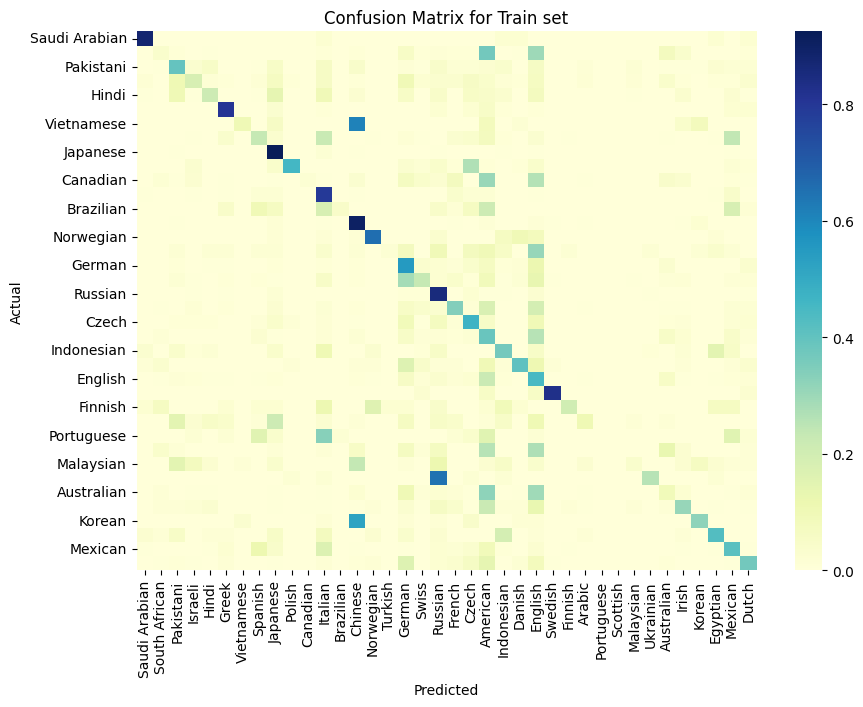

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
sns.heatmap(train_df, cmap="YlGnBu")
plt.title("Confusion Matrix for Train set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
test_loss = 0
test_acc = 0
test_len = sum([len(category_lines_test[x]) for x in all_categories])

test_confusion_matrix = {}
for true_category in all_categories:
    for pred_category in all_categories:
        test_confusion_matrix[(true_category, pred_category)] = 0

for category in all_categories:
    for line in category_lines_test[category]:
        category_tensor, line_tensor = test_example(category, line)
        output = evaluate(line_tensor)
        pred = categoryFromOutput(output)
        test_loss += criterion(output, category_tensor)
        right = 1 if pred[0] == category else 0
        test_acc += right
        test_confusion_matrix[(category, pred[0])] += 1

In [ ]:
final_test_conf_mat = []
for i in range(len(all_categories)):
    final_test_conf_mat.append([])
    for j in range(len(all_categories)):
        final_test_conf_mat[i].append(test_confusion_matrix[(all_categories[i], all_categories[j])])
    real_i_sum = sum(final_test_conf_mat[i])
    for j in range(len(all_categories)):
        final_test_conf_mat[i][j] = final_test_conf_mat[i][j] / real_i_sum

test_df = pd.DataFrame(final_test_conf_mat, index=all_categories, columns=all_categories)

print(test_df)

acc_per_cat_test = {}
top_10_cat_test = []
worst_10_cat_test = []
for i in range(len(all_categories)):
    acc_per_cat_test[all_categories[i]] = final_test_conf_mat[i][i]

acc_per_cat_test = sorted(acc_per_cat_test.items(), key=lambda item: item[1], reverse=False)
for i in range(10):
    top_10_cat_test.append(acc_per_cat_test[len(all_categories) - 1 - i])
    worst_10_cat_test.append(acc_per_cat_test[i])
print("top 10:")
print(top_10_cat_test)

print("worst 10:")
print(worst_10_cat_test)

avg_test_loss = test_loss / test_len
avg_test_acc = test_acc / test_len

print(f"test_acc: {avg_test_acc}")
print(f"test_loss: {avg_test_loss}")

               Saudi Arabian  South African  ...   Mexican     Dutch
Saudi Arabian       0.555556       0.000000  ...  0.055556  0.000000
South African       0.000000       0.000000  ...  0.015504  0.000000
Pakistani           0.000000       0.000000  ...  0.030303  0.030303
Israeli             0.000000       0.000000  ...  0.019231  0.019231
Hindi               0.000000       0.000000  ...  0.015873  0.015873
Greek               0.000000       0.000000  ...  0.017241  0.017241
Vietnamese          0.000000       0.000000  ...  0.000000  0.000000
Spanish             0.000000       0.000000  ...  0.318182  0.022727
Japanese            0.000000       0.000000  ...  0.003367  0.000000
Polish              0.000000       0.000000  ...  0.000000  0.023810
Canadian            0.000000       0.035714  ...  0.011905  0.023810
Italian             0.004739       0.000000  ...  0.052133  0.000000
Brazilian           0.000000       0.000000  ...  0.407407  0.000000
Chinese             0.000000      

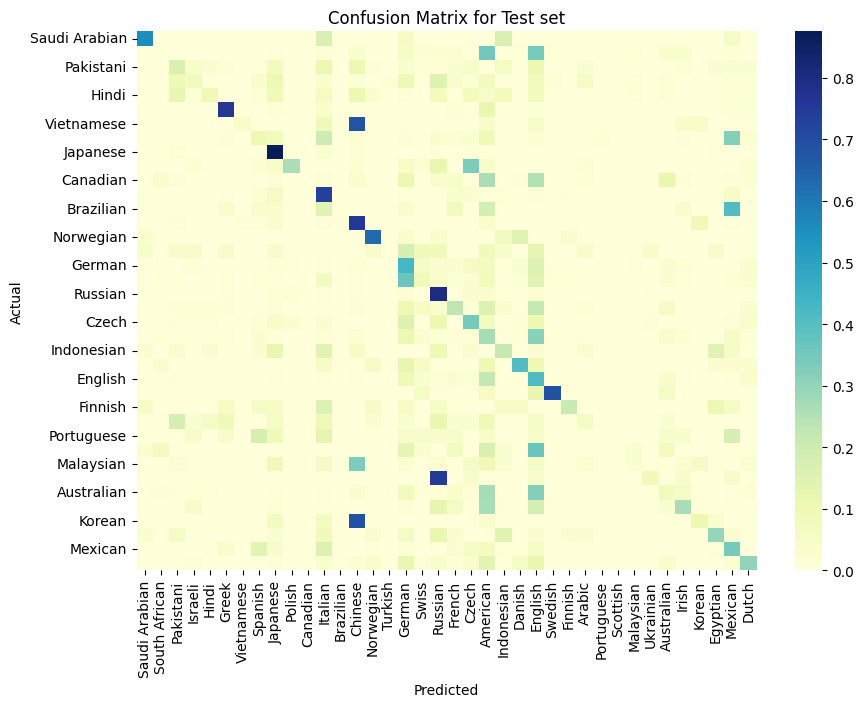

In [ ]:
plt.figure(figsize=(10, 7))
sns.heatmap(test_df, cmap="YlGnBu")
plt.title("Confusion Matrix for Test set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Create Diversity Badge


## extract names for the final project


In [ ]:
from pyspark.sql.functions import col, size, expr, udf, row_number, count, max, explode, dense_rank, when, col
import pyspark.sql.functions as F
from pyspark.sql.window import Window

#### Data from DataBricks

In [ ]:
profiles = spark.read.parquet('/linkedin/people')
companies = spark.read.parquet('/linkedin/companies')

In [ ]:
def clean_data(df, columns):
    for column in columns:
        df = df.withColumn(column, when((col(column) == 'N/A') | (col(column) == 'null') | (col(column) == '--'), None).otherwise(col(column)))
    return df

In [ ]:
employees = profiles.select([
    col("name"),
    col("position").alias("job_title"),
    col("current_company.name").alias("company"),
    ])
cleaned_employees = clean_data(employees, ["job_title", "company"])
display(cleaned_employees)
companies_names=companies.select([
    col("name").alias("company_name")]).distinct()
display(companies_names)

name,job_title,company
cody gardiner,Special Services Director at Sunnyside Unified School District,Sunnyside Unified School District
Sharon Tunnell,Retired at N/A,null
Teresa Fulford,null,null
Noah King,Military Pay Technician at DEFENSE FINANCE AND ACCOUNTING SERVICE-CLEVELAND Retired Annuitant Pay Cleveland Ohio,DFAS
Cynthia Flowers,Senior Underwriter at Tokio Marine Insurance,Tokio Marine Insurance
רבקה פישביין,null,null
Mc kinley Stockton,null,null
Conar Rochford,null,null
Theresa O.,Traffic control supervisor/T.C.L. Union member 242 Laborers union,local 242 Laborers union
Megan Vaske,Doctor of Occupational Therapy Student,null


company_name
pruebatest_1
ELK Investors
Network-NewsCorp
NEW VIP AUTO CENTER INC
GILCHRIST COMMUNITY ASSOCIATION INC
"CPR PROPERTIES, LLC"
"IRENE T. THEODORE, D.D.S., LTD."
DETROIT LAKES STRIKERS SOCCER CLUB INC
PREFERRED CUSTOM HOMES OF ALASKA INC
NORCROSS DENTAL ASSOCIATES


##### Data from scrap

In [ ]:
import pandas as pd
with open(rf'{proj_dir}/data/scrapedData/employees_from_scrap.csv', 'rb') as f:
    employees_from_scrap = pd.read_csv(f)
employees_from_scrap["name"] = employees_from_scrap["name_from_title"].apply(lambda x: x.split(" ")[-1])
employees_from_scrap=employees_from_scrap[["name", "company", "job_title"]]
employees_from_scrap = spark.createDataFrame(employees_from_scrap)
cleaned_emp=clean_data(employees_from_scrap, ["job_title", "company"])
# extaned the employees with the employees from scrap
# employees = employees.union(employees_from_scrap)





## Apply origin country model


In [ ]:
cleaned_employees_no_special_chars = cleaned_employees.filter(~F.col("name").rlike("[^a-zA-Z\s]"))
cleaned_employees_no_special_chars.show(5)

+---------------+--------------------+--------------------+
|           name|           job_title|             company|
+---------------+--------------------+--------------------+
|  cody gardiner|Special Services ...|Sunnyside Unified...|
| Sharon Tunnell|      Retired at N/A|                NULL|
| Teresa Fulford|                NULL|                NULL|
|      Noah King|Military Pay Tech...|                DFAS|
|Cynthia Flowers|Senior Underwrite...|Tokio Marine Insu...|
+---------------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
from pyspark.sql.types import BooleanType
from pyspark.sql.types import ArrayType, FloatType
from pyspark.sql.functions import udf

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Define a function that applies evaluate and categoryFromOutput to a name
def evaluate_and_get_category(name):
    name_tensor = lineToTensor(name)
    output = evaluate(name_tensor)
    # category = categoryFromOutput(output)[0]
    return output.tolist()[0]

# Convert the function into a UDF
evaluate_and_get_category_udf = udf(evaluate_and_get_category,ArrayType(FloatType()))

# Filter rows where the name have spcial charctars
cleaned_employees_no_special_chars = cleaned_employees.filter(~F.col("name").rlike("[^a-zA-Z\s]"))

# Create a new column based on 'name' column
cleaned_employees_last_name = cleaned_employees_no_special_chars.withColumn('last_name', F.split(F.col('name'), ' ')[1])

# Drop rows where new column is null
cleaned_employees_last_name = cleaned_employees_last_name.filter(F.col('last_name').isNotNull()).filter(F.col('company').isNotNull())
# Run the model on each row and create a new column with the result
# Assuming run_model_udf is a UDF that wraps the model function
cleaned_employees_last_name = cleaned_employees_last_name.withColumn('model_result', evaluate_and_get_category_udf(F.col('last_name')))

cleaned_employees_last_name.show(5)


+---------------+--------------------+--------------------+---------+--------------------+
|           name|           job_title|             company|last_name|        model_result|
+---------------+--------------------+--------------------+---------+--------------------+
|  cody gardiner|Special Services ...|Sunnyside Unified...| gardiner|[-4.009631, -2.44...|
|      Noah King|Military Pay Tech...|                DFAS|     King|[-8.813881, -3.67...|
|Cynthia Flowers|Senior Underwrite...|Tokio Marine Insu...|  Flowers|[-14.265334, -1.9...|
| Taylor Vickers|Director at Repub...|   Republic Services|  Vickers|[-13.024193, -2.8...|
|    Cami German|Teacher at Round ...|      Round Rock ISD|   German|[-9.592841, -2.52...|
+---------------+--------------------+--------------------+---------+--------------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import explode
# cleaned_employees_last_name_sub = cleaned_employees_last_name.limit(10)
# Explode the 'model_result' column into separate rows
df = cleaned_employees_last_name.select('*', explode(F.col("model_result")).alias('model_result_exploded'))

# Group by 'company' and calculate variance
df_grouped = df.groupBy('company').agg(F.variance('model_result_exploded').alias('variance'))

df_grouped.show()

+--------------------+------------------+
|             company|          variance|
+--------------------+------------------+
|Amazon Web Servic...| 6.847137698459951|
|Mountain View Sur...| 5.568867552455805|
|Ohio Valley Healt...| 6.714575439323223|
|   Baxter Healthcare|7.3666701388608455|
|Simply Savvy Desi...| 3.668436879753417|
|Stonehaven Proper...| 7.832714104920322|
|                 ...|  7.02763335121061|
|Grand Casino Hinc...| 6.764278651543533|
|         Houston ISD| 6.793410294017558|
|    Colorado College| 6.485671520345861|
|A-Affordable Insu...|  8.24115486440569|
|The Seattle Publi...| 4.847182872306454|
|Washington County...|  7.78236526471248|
|   Energy Technology| 2.270871128298413|
|        4 Today Inc.| 8.653247069167582|
|TMS Event Management| 5.758890312418676|
|Harwood Internati...| 6.549183180471336|
|Sioux Falls Schoo...| 7.036241687021254|
|           ACE Glass| 9.071256857651282|
|Lakeland Tool & E...| 8.755421592665943|
+--------------------+------------

In [ ]:
from pyspark.sql import functions as F

df_sorted = df_grouped.orderBy(F.desc('variance'))

df_sorted.show()

+--------------------+------------------+
|             company|          variance|
+--------------------+------------------+
| Java Holdings, Inc.| 23.04982945540302|
|     Carma Connected| 19.41250031024308|
|   The Haley Mansion|18.909555169861637|
|     Magnum Pomskies| 18.89028645193192|
| Squarepoint Capital|18.846591165235864|
|Epworth Village, ...|18.778431798639243|
|       Jordan Toyota| 18.71579688002102|
|Michigan Solar So...| 18.59152185360918|
|      Bayside Church|18.561624332991972|
|     TC Custom Decks| 18.49636921419283|
|  Smart Vision Works| 18.49636921419283|
|Tippetts Joint Ve...| 18.49636921419283|
|        KT Cart-Away| 18.49636921419283|
|Financial Equitie...| 18.48398343734769|
|Kompowsky Service...|18.477639000674422|
|Detroit Machine T...|18.378351113308987|
|1st Stop Properti...|18.378351113308987|
| Windham High School| 18.30918061544523|
|nickels portable ...|18.227804348981905|
|  Hardware Hills LLC|18.227804348981905|
+--------------------+------------

In [ ]:
window_spec = Window.orderBy(F.desc("variance"))

# Add a new column with dense rank
df_sorted_ranked = df_sorted.withColumn("diversity_rank", dense_rank().over(window_spec))

In [ ]:
chosen_companies = df_sorted_ranked.filter((df_sorted.company == "Microsoft")| (df_sorted.company == "Amazon") | (df_sorted.company == "Google") | (df_sorted.company == "Meta") | (df_sorted.company == "Apple inc.") | (df_sorted.company == "Netflix") | (df_sorted.company == "Tesla") | (df_sorted.company == "Uber") | (df_sorted.company == "Lyft") | (df_sorted.company == "Airbnb") | (df_sorted.company == "Slack") | (df_sorted.company == "Pinterest") | (df_sorted.company == "Snapchat") | (df_sorted.company == "Twitter") | (df_sorted.company == "Dropbox"))
pd.DataFrame(chosen_companies)

company,variance,diversity_rank
Slack,7.383987858820502,126538
Pinterest,7.319402306411245,131517
Lyft,7.228808631745701,138741
Airbnb,7.1789255392838145,142746
Google,7.032758917985155,154672
Netflix,7.001920610125378,157193
Uber,6.9809385697845965,158852
Tesla,6.976770631790378,159176
Amazon,6.920763387689685,163772
Meta,6.886156623999976,166523


In [ ]:
# Get the number of rows in the DataFrame
num_rows = df_sorted.count()

# Calculate the number of rows in the top 1%
num_top_1_percent = int(num_rows * 0.01)

# Take the top 1% of rows
df_top_1_percent = df_sorted.limit(num_top_1_percent)

df_top_1_percent.show()

com.databricks.backend.common.rpc.CommandCancelledException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$3(SequenceExecutionState.scala:103)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$2(SequenceExecutionState.scala:103)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$2$adapted(SequenceExecutionState.scala:100)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:100)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:714)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:430)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:430)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecutio

In [ ]:
print(num_top_1_percent)

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$2(SequenceExecutionState.scala:105)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$2$adapted(SequenceExecutionState.scala:100)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:100)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:714)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:430)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:430)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecution(ChauffeurState.scala:1225)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:958)
	at com.databricks.logging.UsageL

In [ ]:
# Calculate the 99th percentile of the 'variance' column
threshold = df_grouped.approxQuantile('variance', [0.99], 0.01)[0]

# Filter the DataFrame to get the records of the highest 1% values
df_top_1_percent = df_grouped.filter(df_grouped.variance >= threshold)

df_top_1_percent.show()

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$2(SequenceExecutionState.scala:105)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$2$adapted(SequenceExecutionState.scala:100)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:100)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:714)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:430)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:430)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecution(ChauffeurState.scala:1225)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:958)
	at com.databricks.logging.UsageL

In [ ]:
print(threshold)

com.databricks.backend.common.rpc.CommandSkippedException
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$2(SequenceExecutionState.scala:105)
	at com.databricks.spark.chauffeur.SequenceExecutionState.$anonfun$cancel$2$adapted(SequenceExecutionState.scala:100)
	at scala.collection.immutable.Range.foreach(Range.scala:158)
	at com.databricks.spark.chauffeur.SequenceExecutionState.cancel(SequenceExecutionState.scala:100)
	at com.databricks.spark.chauffeur.ExecContextState.cancelRunningSequence(ExecContextState.scala:714)
	at com.databricks.spark.chauffeur.ExecContextState.$anonfun$cancel$1(ExecContextState.scala:430)
	at scala.Option.getOrElse(Option.scala:189)
	at com.databricks.spark.chauffeur.ExecContextState.cancel(ExecContextState.scala:430)
	at com.databricks.spark.chauffeur.ChauffeurState.cancelExecution(ChauffeurState.scala:1225)
	at com.databricks.spark.chauffeur.ChauffeurState.$anonfun$process$1(ChauffeurState.scala:958)
	at com.databricks.logging.UsageL